In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate
from torchinfo import summary
from torchvision import transforms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from typing import Iterable
from tqdm import tqdm
from nguyenpanda.swan import green
import nguyenpanda.crow as crow

from pathlib import Path

In [3]:
plt.style.use('dark_background')

DEVICE = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else
          'cpu')
print(green(DEVICE))

IN_COLAB = crow.nb_utils.is_colab()
print(green(IN_COLAB))

cpu
False


In [4]:
dataset = crow.Dataset('MNIST').alias('/Users/hatuongnguyen/datasets/MNIST_CSV')

Directory "/Users/hatuongnguyen/Learning/PyTorch/model/mnist_autoencoder/MNIST" already exists!


In [5]:
class MyDataset(Dataset):

    def __init__(self, csv_path: Path,
                 transform,
                 xy_range: Iterable[int] = (5, 15),
                 wh_range: Iterable[int] = (7, 15)):
        super().__init__()
        self.trans = transform
        self.df = pd.read_csv(csv_path)
        self.path = csv_path
        self.xy_range = xy_range
        self.wh_range = wh_range

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item: int):
        _data = self.df.iloc[item]

        y = _data.iloc[1:].to_numpy().reshape((28, 28)).copy().astype(np.uint8)

        x = y.copy()
        _xy = np.random.randint(*self.xy_range, size=(2,))  # TODO: Change
        _wh = np.random.randint(*self.wh_range, size=(2,))  # TODO: Change

        _a = np.minimum(_xy + _wh, 27)
        x[_xy[0]:_a[0], _xy[1]:_a[1]] = 0

        return self.trans(x), self.trans(y)

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MyDataset(dataset / 'train.csv', train_transform)
test_dataset = MyDataset(dataset / 'test.csv', test_transform)

print(len(train_dataset), len(test_dataset))

60000 10000


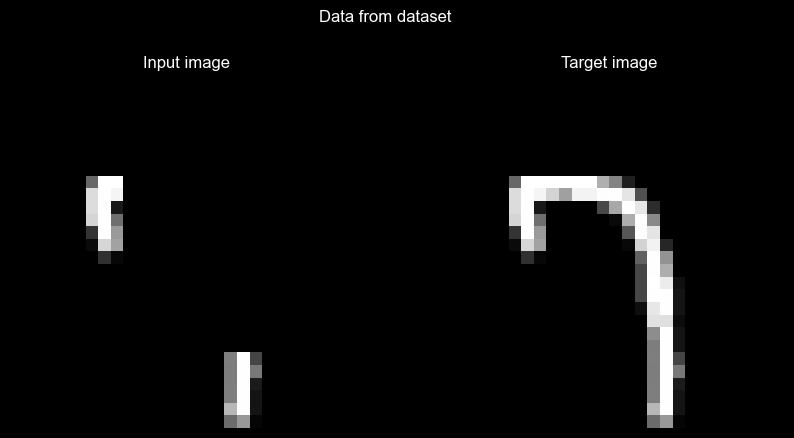

In [58]:
data = train_dataset[random.randint(0, 10000)]

fig = plt.figure(figsize=(10, 5))

fig.suptitle('Data from dataset')

ax = plt.subplot(1, 2, 1)
ax.imshow(data[0].squeeze(), cmap='gray')
ax.set_title('Input image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(data[1].squeeze(), cmap='gray')
ax.set_title('Target image')
ax.axis('off')

plt.show()

In [8]:
def collate_func(batch_list):
    return tuple(_tensor.to(DEVICE) for _tensor in default_collate(batch_list))


BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func)

batch = next(iter(train_loader))
print(type(batch), len(batch))
print(batch[0].shape)
print(batch[1].shape)

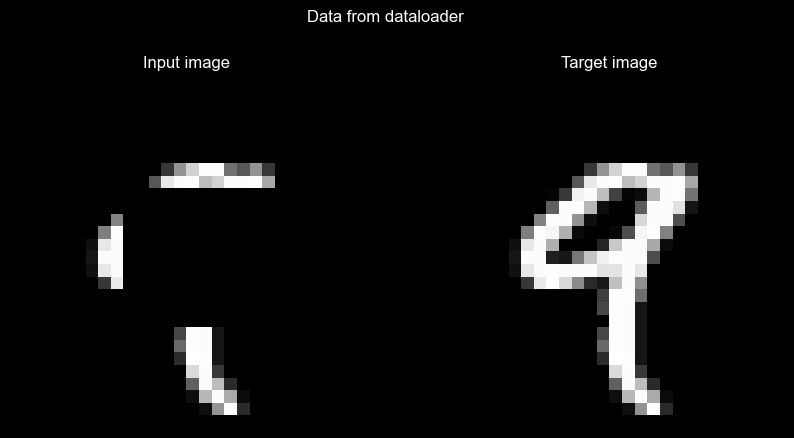

In [57]:
idx = random.randint(0, 31)

fig = plt.figure(figsize=(10, 5))

fig.suptitle('Data from dataloader')

ax = plt.subplot(1, 2, 1)
data = batch[0][idx]
ax.imshow(data[0].squeeze(), cmap='gray')
ax.set_title('Input image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
data = batch[1][idx]
ax.imshow(data[0].squeeze(), cmap='gray')
ax.set_title('Target image')
ax.axis('off')

plt.show()

In [13]:
class MyGodDamnModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.train_call = 0
        self.zip = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        )

        self.unzip = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.zip(x)
        return self.unzip(x)

    def test_step(self, dataloader, loss_function):
        total_batch = len(dataloader)
        total_loss = 0

        self.eval()
        with torch.inference_mode():
            for b, (x, y) in enumerate(dataloader, 1):
                logit = self.forward(x)
                loss = loss_function(logit, y)

                total_loss += loss.item()
        return total_loss / total_batch

    def train_step(self, dataloader, loss_function, optimizer):
        self.train_call += 1
        total_batch = len(dataloader)
        b_pad = len(str(total_batch))
        total_loss = 0

        self.train()
        for b, (x, y) in enumerate(dataloader, 1):
            logit = self.forward(x)

            loss = loss_function(logit, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            text = '{: >{}}/{} | ins_loss = \033[1;92m{: >10.5f}\033[0m'
            if IN_COLAB:
                text = '\r' + text
            else:
                text = text + '\r'
            print(text.format(b, b_pad, total_batch, loss.item()), end='')
        print()

        return total_loss / total_batch

In [14]:
def wrap_value(value):
    return green(f'{value: >8.5f}')


EPOCHS = 50
LEARNING_RATE = 5e-4
HIDDEN_CHANNEL = 40

history = dict(train_loss=[], test_loss=[])
model = MyGodDamnModel().to(DEVICE)

loss_func = nn.BCEWithLogitsLoss()
opti = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

print('EPOCHS:', green(EPOCHS))
print('LEARNING_RATE:', green(LEARNING_RATE))
print('loss_func:', green(loss_func))
print('opti:', green(opti.__class__.__name__))

summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

EPOCHS: 50
LEARNING_RATE: 0.0005
loss_func: BCEWithLogitsLoss()
opti: Adam


Layer (type:depth-idx)                   Output Shape              Param #
MyGodDamnModel                           [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 128, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 14, 14]          18,496
│    └─ReLU: 2-5                         [32, 64, 14, 14]          --
│    └─MaxPool2d: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 7, 7]           73,856
├─Sequential: 1-2                        [32, 1, 28, 28]           --
│    └─Conv2d: 2-8                       [32, 64, 7, 7]            73,792
│    └─ReLU: 2-9                         [32, 64, 7, 7]            --
│    └─Upsample: 2-10                    [32, 64, 14, 14]          --
│ 

In [15]:
MODEL_FILE_NAME = 'zip_unzip.pt'
MODEL_PATH: Path = Path('/content/drive/MyDrive/Colab Notebooks/zip_unzip') if IN_COLAB else Path(Path.cwd() / 'parameter')

_max_test_loss: int = -1

for e in tqdm(range(1, EPOCHS + 1), desc='Epoch: '):
    train_loss = model.train_step(train_loader, loss_func, opti)
    test_loss = model.test_step(test_loader, loss_func)
    print('train_loss = {} | test_loss = {}'.format(
        wrap_value(train_loss), wrap_value(test_loss),
    ))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    if _max_test_loss <= test_loss:
        _max_test_loss = test_loss

        if not MODEL_PATH.is_dir():
            MODEL_PATH.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), MODEL_PATH / MODEL_FILE_NAME)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [17]:
print(MODEL_PATH)

model_load = MyGodDamnModel().to(DEVICE)
model_load.load_state_dict(torch.load(MODEL_PATH / 'google_colab.pt', map_location=torch.device('cpu')))

/Users/hatuongnguyen/Learning/PyTorch/model/mnist_autoencoder/parameter


<All keys matched successfully>

tensor(34.1373)
tensor(66.3686)
tensor(-12979.2002)
tensor(-12979.2002)
tensor(-0.3271)


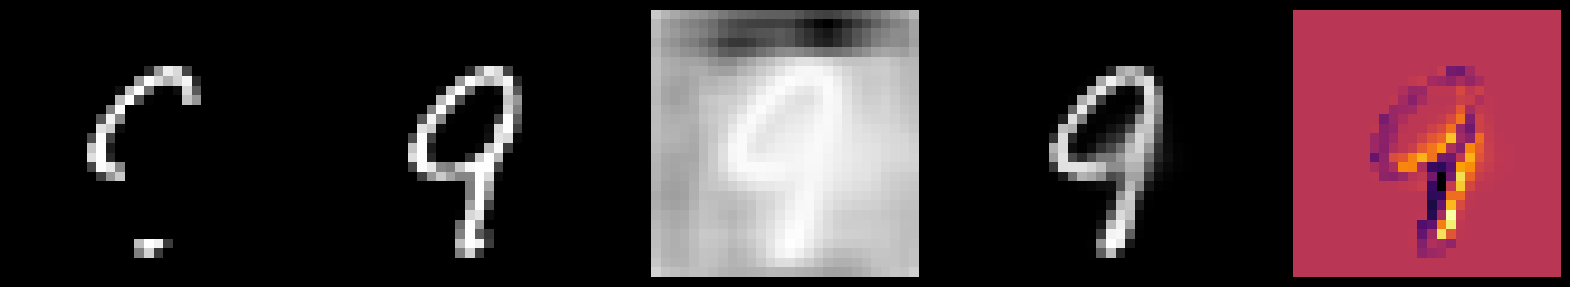

In [18]:
from matplotlib.image import imsave

for i, a in enumerate(test_loader):
    if i == 3:
        break

model_load.eval()
with torch.inference_mode():
    output = model_load(a[0])

idx = random.randint(0, 31)

plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 5, 1)
target = a[0][idx]
ax.imshow(target[0].squeeze(), cmap='gray')
ax.axis('off')
print(torch.sum(target[0]))

ax = plt.subplot(1, 5, 2)
miss = a[1][idx]
ax.imshow(miss[0].squeeze(), cmap='gray')
ax.axis('off')
print(torch.sum(miss[0]))

ax = plt.subplot(1, 5, 3)
ax.imshow(output[idx].squeeze(), cmap='gray')
ax.axis('off')
print(torch.sum(output[idx]))

ax = plt.subplot(1, 5, 4)
_output = torch.sigmoid(output)
ax.imshow(_output[idx].squeeze(), cmap='gray')
ax.axis('off')
print(torch.sum(output[idx]))

ax = plt.subplot(1, 5, 5)
delta = _output[idx] - miss
ax.imshow(delta.squeeze(), cmap='inferno')
ax.axis('off')
print(torch.sum(delta))

plt.show()

In [19]:
VALIDATION_PATH: Path = Path.cwd() / 'validation'
print(VALIDATION_PATH)


class ValidationDataset(Dataset):

    def __init__(self, path: Path, transform):
        self.path = path
        self.list_img = list(path.glob('*.png'))
        self.trans = transform

    def __len__(self):
        return len(self.list_img)

    def __getitem__(self, item) -> torch.Tensor:
        img = self.get_img(item)

        _xy = np.random.randint(5, 15, size=(2,))  # TODO: Change
        _wh = np.random.randint(7, 15, size=(2,))  # TODO: Change
        _a = np.minimum(_xy + _wh, 27)

        img[_xy[0]:_a[0], _xy[1]:_a[1]] = 0
        return self.trans(img)

    def get_img(self, item):
        img_path = self.list_img[item]
        img = plt.imread(img_path)
        if img.ndim > 1:
            img = img[..., 0]
        return img

/Users/hatuongnguyen/Learning/PyTorch/model/mnist_autoencoder/validation


In [20]:
validation_dataset = ValidationDataset(VALIDATION_PATH, train_transform)

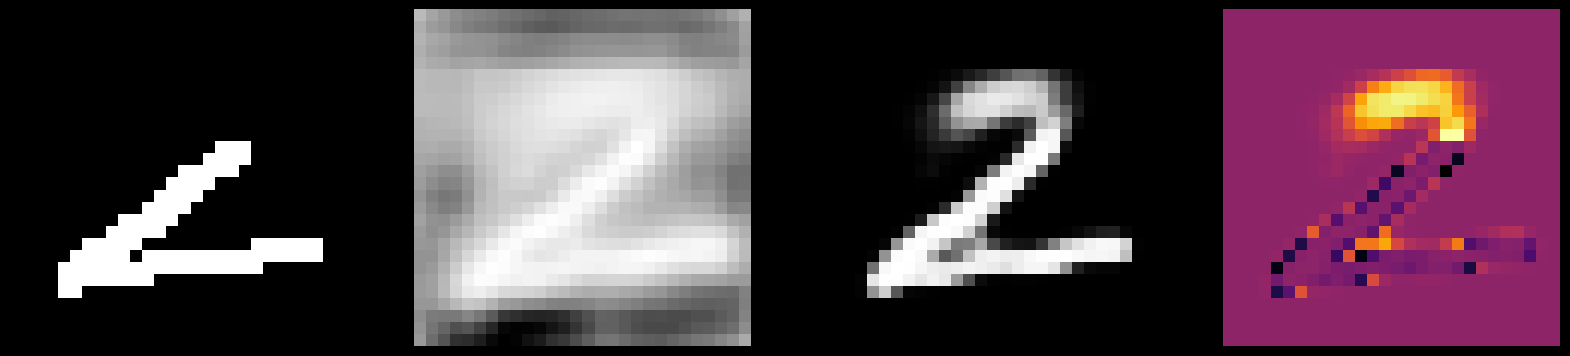

In [50]:
# img = validation_dataset[2].unsqueeze(dim=0)
img = torch.tensor(plt.imread(
    '/Users/hatuongnguyen/NguyenLibrary/florentino/demo/mnist/drawn_image.png'
)).reshape(1, 1, 28, 28)


plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 4, 1)
ax.imshow(img.squeeze().numpy(), cmap='gray')
ax.axis('off')

ax = plt.subplot(1, 4, 2)
model_load.eval()
with torch.inference_mode():
    logit_img = model_load(img)
ax.imshow(logit_img.squeeze().numpy(), cmap='gray')
ax.axis('off')

ax = plt.subplot(1, 4, 3)
tar = torch.sigmoid(logit_img)
ax.imshow(tar.squeeze().numpy(), cmap='gray')
ax.axis('off')

ax = plt.subplot(1, 4, 4)
delta = tar - img
ax.imshow(delta.squeeze().numpy(), cmap='inferno')
ax.axis('off')

plt.show()